- https://www.kaggle.com/crawford/cat-dataset

In [1]:
import random
import math
import time
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
INPUT_PATH = "../input/cat-dataset/CAT_00"
img_path_list = glob.glob(os.path.join(INPUT_PATH,"*.jpg"))
print(len(img_path_list))

1706


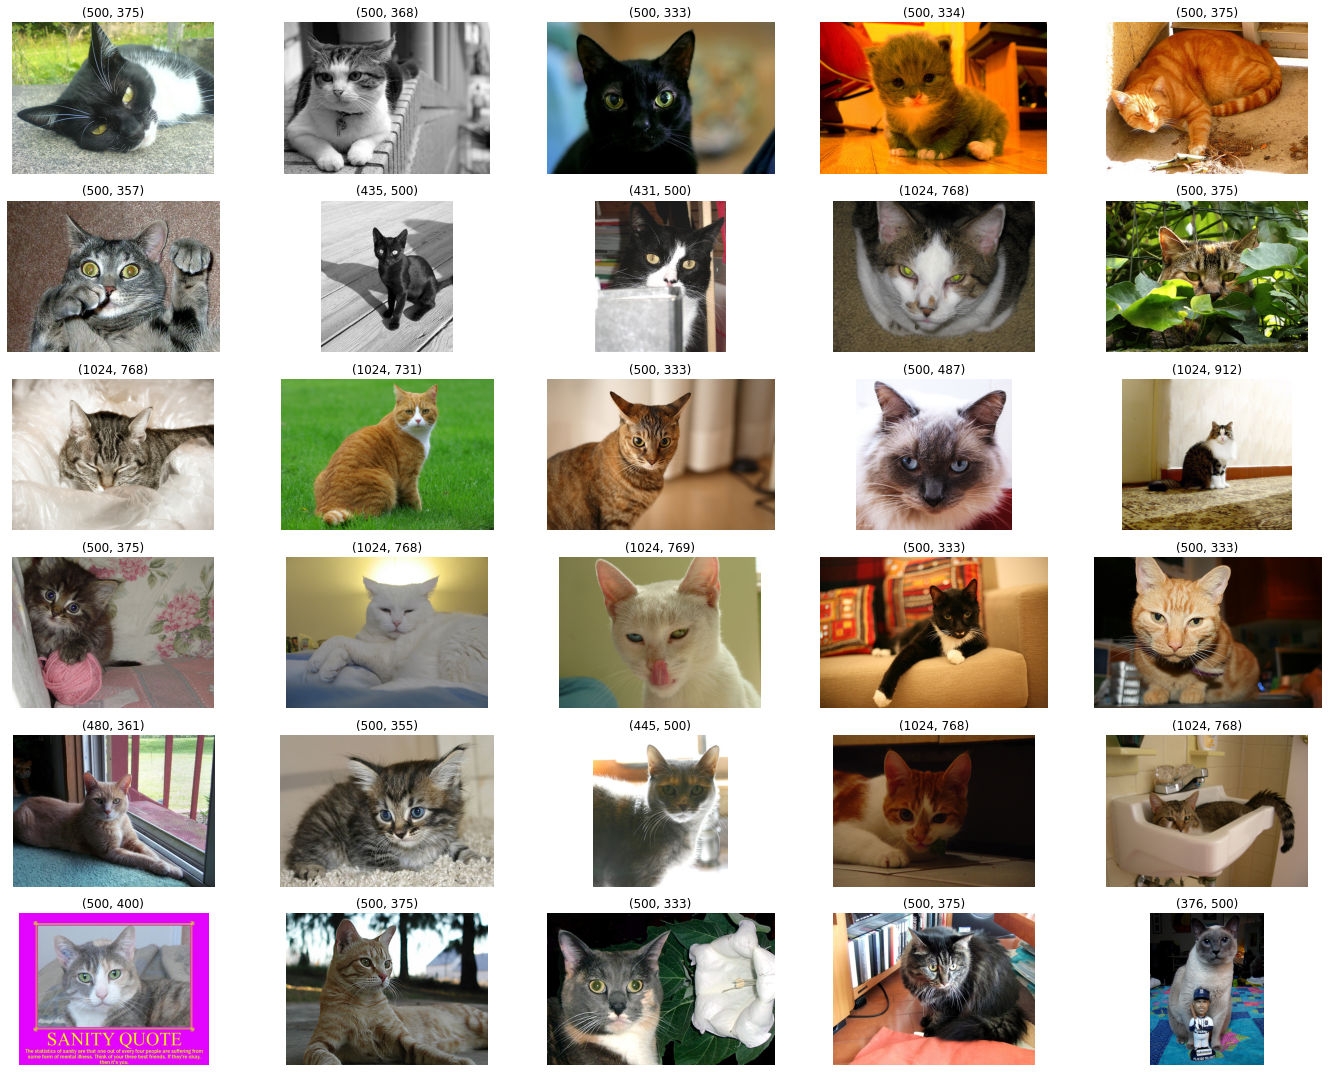

In [4]:
plt.figure(figsize=(20,15),tight_layout = True)
for i in range(30):
    plt.subplot(6,5,i+1)
    img = Image.open(img_path_list[i])
    plt.imshow(img)
    plt.axis("OFF")
    plt.title(img.size)

- 画像サイズがバラバラなので、cropする必要あり。
    - 64:64でresizeとcenter-cropしようかな

# GCGAN実装
- SAGANも実装したいけど、Self-attentionの実装だるそうなので、一旦GCGAN
- pytorch本　　p246~基本そのままもらう
- ただしカラー画像なので気をつける

In [5]:
def seed_everything():
    torch.manual_seed(1234)
    np.random.seed(1234)
    random.seed(1234)
seed_everything() 

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size = 64):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, # 潜在次元 in_channle
                               image_size*8, #  out_channel 
                               kernel_size = 4,
                               stride = 1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, # 潜在次元 in_channle
                               image_size*4, #  out_channel 
                               kernel_size = 4,
                               stride = 2,
                               padding = 1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, 
                               image_size * 2,
                               kernel_size=4, 
                               stride=2, 
                               padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, 
                               image_size,
                               kernel_size=4, 
                               stride=2, 
                               padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 
                               3, #カラー画像なのでここは3にしておく
                               kernel_size=4,
                               stride=2, 
                               padding=1),
            nn.Tanh())

    def forward(self, z):
        '''
        バグだしのためにprintでshape取っておく
        '''
        #print(f"z_shape :{z.shape}")
        out = self.layer1(z)
        #print(f"layer1_out_shape : {out.shape}")
        out = self.layer2(out)
        #print(f"layer2_out_shape : {out.shape}")
        out = self.layer3(out)
        #print(f"layer3_out_shape : {out.shape}")
        out = self.layer4(out)
        #print(f"layer4_out_shape : {out.shape}")
        out = self.last(out)
        #print(f"layer5_out_shape : {out.shape}")
        return out

fake_img_shape:torch.Size([1, 3, 64, 64])


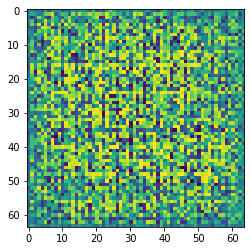

In [7]:
# 動作確認
G = Generator(z_dim = 20, image_size = 64)
# 乱数
input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1,1)
# output
fake_images = G(input_z)
print(f"fake_img_shape:{fake_images.shape}")

#
img_transformed = fake_images[0][0].detach().numpy() # https://teratail.com/questions/234693 detachについて
plt.imshow(img_transformed)
plt.show()

- b:ch:w:h = 1:3:64:64なのでok

# Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self,image_size = 64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, # in_channelはカラーなので3
                      image_size,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, 
                      image_size*2,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, 
                      image_size*4,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, 
                      image_size*8,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        return out

In [9]:
# 動作確認
D = Discriminator(image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[[[0.5033]]]], grad_fn=<SigmoidBackward>)


# dataloader作成

In [10]:
def make_img_path_list(use_dir_num):
    '''
    画像格納フォルダははCAT_00~CAT06まである。どこまで使うか指定して、そこまでの画像pathのリストを返す
    '''
    train_img_list = []
    for i in range(use_dir_num):
        use_dir = f"../input/cat-dataset/CAT_0{i}"
        paths = glob.glob(os.path.join(use_dir,"*.jpg"))
        train_img_list+=paths
        print("num_img",len(train_img_list))
    return train_img_list

In [11]:
train_img_list = make_img_path_list(7)

num_img 1706
num_img 3324
num_img 5081
num_img 5892
num_img 7288
num_img 8609
num_img 9997


In [12]:
# transform
IMG_MEAN = [0.5, 0.5, 0.5]
IMG_STD = [0.5, 0.5, 0.5]
size = (64,64)

data_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(), 
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])

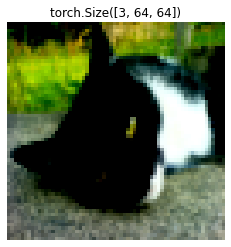

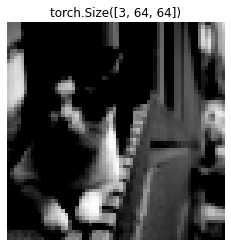

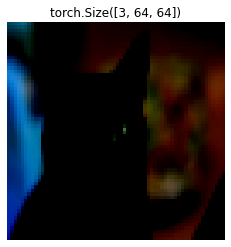

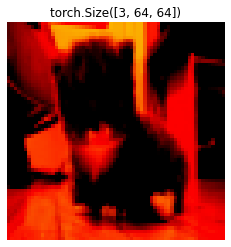

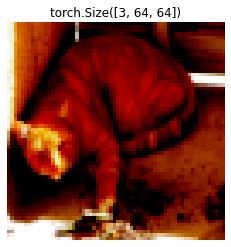

In [13]:
# transform動作確認
for i in range(5):
    img = Image.open(img_path_list[i])
    x = data_transform(img)
    plt.title(x.shape)
    plt.imshow(x.permute(1,2,0))
    plt.axis("off")
    plt.show()

- 画素荒いし、やばそうな気配がする...バケモノができそう...

In [14]:
# dataset class
class GAN_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img = self.transform(img)
        return img

In [15]:
# DataLoaderの作成と動作確認
train_dataset = GAN_Dataset(
    file_list=train_img_list, 
    transform=data_transform)

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 3, 64, 64])


## 学習

In [16]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
# モデルを学習させる関数を作成
def train_model(G, D, dataloader, num_epochs,device):
    # 最適化手法の設定
    g_lr, d_lr = 0.0005, 0.0005
    beta1, beta2 = 0.1, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            label_real = label_real.type_as(d_out_real.view(-1))
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


In [18]:
## 学習・検証を実行する
# 初期化の実施
G = Generator(z_dim = 20, image_size = 64)
D = Discriminator(image_size=64)

G.apply(weights_init)
D.apply(weights_init)
print("ネットワークの初期化完了")

num_epochs = 50
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs, device = device)

ネットワークの初期化完了
-------------
Epoch 0/50
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:3.1613 ||Epoch_G_Loss:2.6586
timer:  171.5136 sec.
-------------
Epoch 1/50
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:3.3966 ||Epoch_G_Loss:2.1409
timer:  98.6470 sec.
-------------
Epoch 2/50
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:3.2942 ||Epoch_G_Loss:2.6108
timer:  98.8395 sec.
-------------
Epoch 3/50
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:3.1748 ||Epoch_G_Loss:2.9368
timer:  98.8502 sec.
-------------
Epoch 4/50
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:3.2539 ||Epoch_G_Loss:2.6424
timer:  98.6347 sec.
-------------
Epoch 5/50
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:3.2330 ||Epoch_G_Loss:2.5656
timer:  98.8047 sec.
-------------
Epoch 6/50
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:3.1388 ||Epoch_G_Loss:2.7011
timer:  99.0376 sec.
-------------
Epoch 7/50
-------------
（t

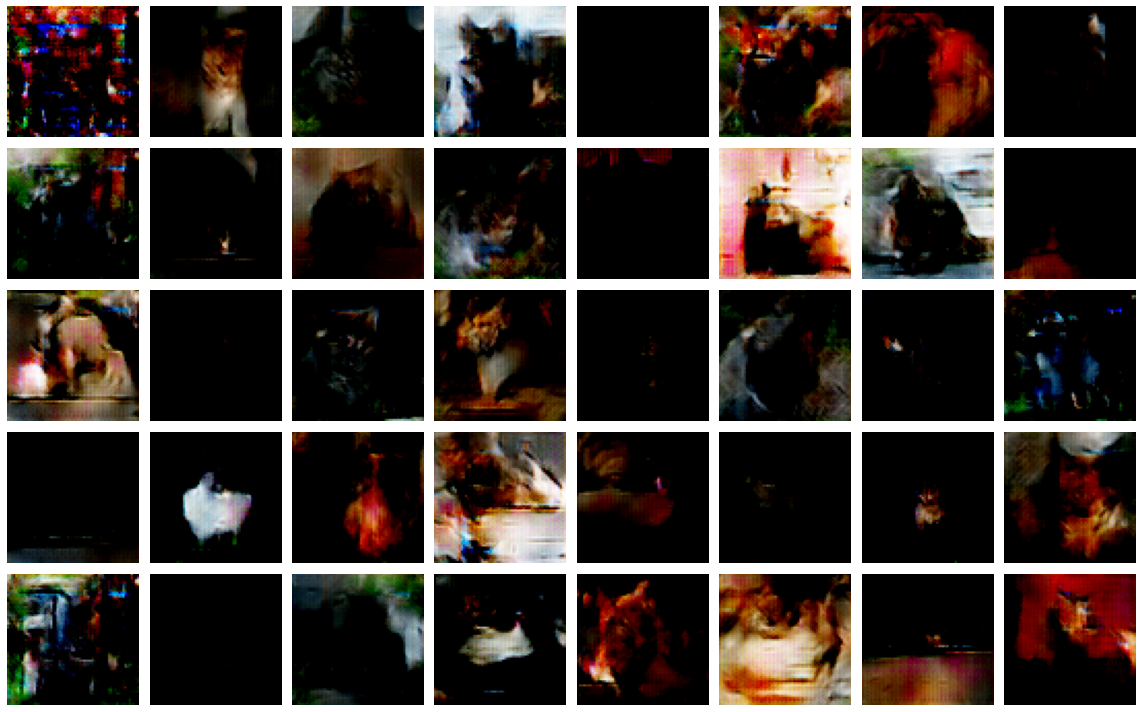

In [19]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

# 入力の乱数生成
batch_size = 40
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 出力
fig = plt.figure(figsize=(16, 10),tight_layout = True)
for i in range(0, 40):
    plt.subplot(5, 8, i+1)
    plt.imshow(fake_images[i].cpu().detach().permute(1,2,0))
    plt.axis("off")

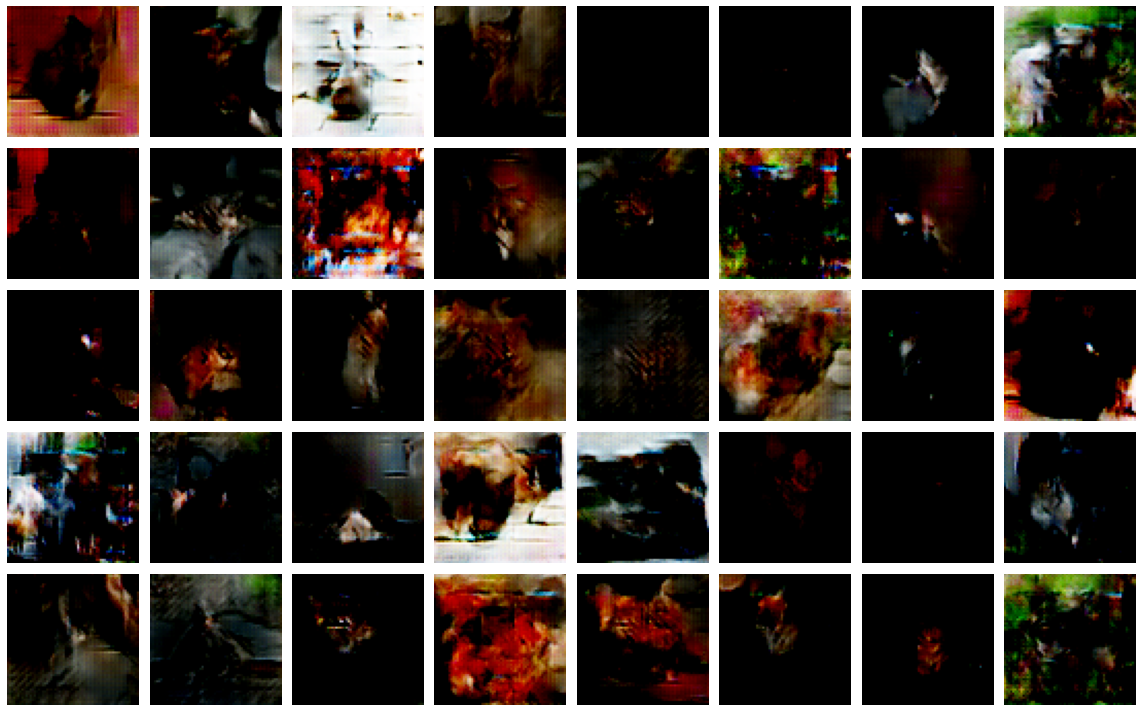

In [20]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

# 入力の乱数生成
batch_size = 40
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 出力
fig = plt.figure(figsize=(16, 10),tight_layout = True)
for i in range(0, 40):
    plt.subplot(5, 8, i+1)
    plt.imshow(fake_images[i].cpu().detach().permute(1,2,0))
    plt.axis("off")

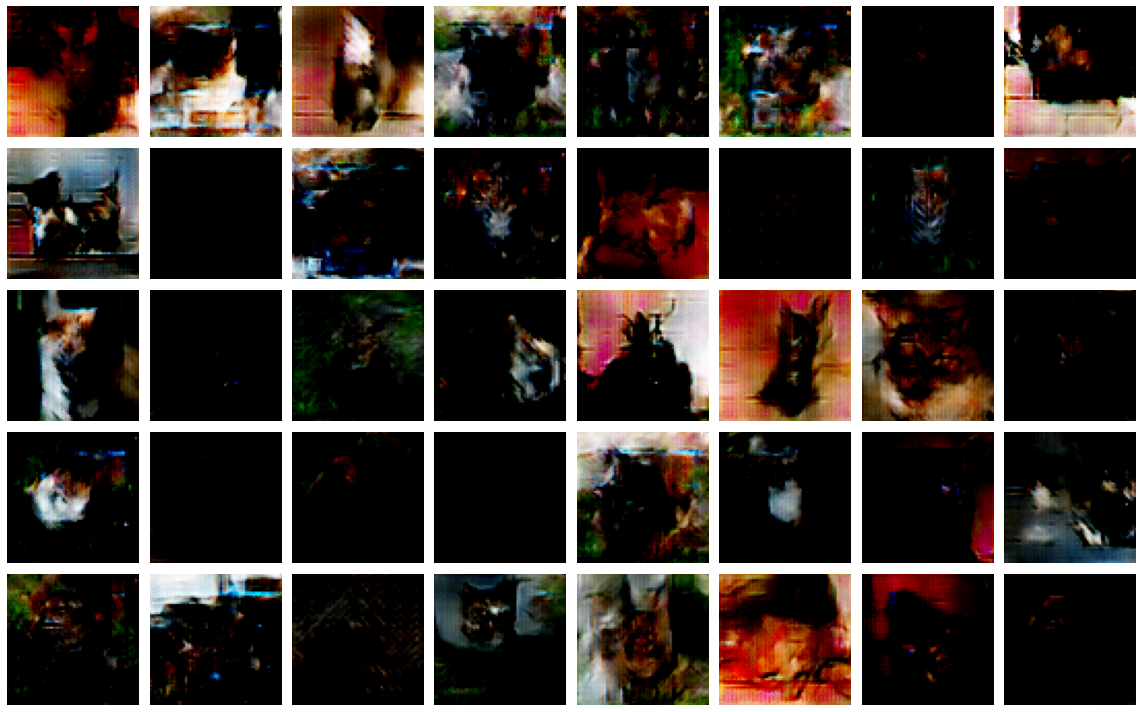

In [21]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

# 入力の乱数生成
batch_size = 40
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 出力
fig = plt.figure(figsize=(16, 10),tight_layout = True)
for i in range(0, 40):
    plt.subplot(5, 8, i+1)
    plt.imshow(fake_images[i].cpu().detach().permute(1,2,0))
    plt.axis("off")